In [1]:
# buckling inputs
# ----------------

import numpy as np
from scipy.optimize import fsolve

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
# D = 1

# choose loading type (first just uniaxial loading in x-direction)
# axial = True
axial = False
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else:
    Nxx, Nxy, Nyy = (0, 1e2, 0)

# a, b = (1, 1)
(a, b) = (3, 1)

# predict the buckling load factor (BLF)
pi = 3.14159
if axial:
    pred_buckling_load = pi**2 * D / b**2 * 4.0 
    pred_load_factor = pred_buckling_load / Nxx
    sigma = 0.5 * pred_load_factor
    print(f"{pred_load_factor=}")
else: # shear case
    def resid(_s2):
        s1_sq = np.sqrt(1.0 + 2.0 * _s2**2 + _s2**4)
        return s1_sq + _s2**2 + 1.0/3.0 - np.sqrt(4.0/9.0 + 4.0/3.0 * s1_sq + 4.0/3.0 * s1_sq**2)

    s2_soln = fsolve(resid, x0=1.0)
    print(f"{s2_soln=}")
    s2 = s2_soln[0]
    s1_sq = np.sqrt(1.0 + 2.0 * s2**2 + s2**4)
    s2_resid = resid(s2)
    print(f"{s2_resid=}")

    # sean's closed-form soln for shear
    pred_buckling_load_star = (1.0 + s1_sq**2 + 6 * s1_sq * s2**2 + s2**4 + 2.0 * (s1_sq + s2**2)) / 2.0 / (s1_sq * s2**2)
    rho = a / b
    ar_factor = np.max([1.0, 1.0/rho**2])
    pred_buckling_load = pi**2 * D / b**2 * pred_buckling_load_star * ar_factor
    
    # from chatgpt pred_buckling_load for shear, simply supported (first estimate)
    # pred_buckling_load = 4 * E / 2.0 / (1 + nu) / thick**2 / (1 - nu**2)
    pred_load_factor = pred_buckling_load / Nxy
    sigma = 0.9 * pred_load_factor
    # sigma = 0.1
    print(f"{pred_load_factor=}")
    # sigma = 50.0

s2_soln=array([0.70710678])
s2_resid=0.0
pred_load_factor=632.6658800064105


2024-12-04 22:52:33.600761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733370753.612062  183795 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733370753.615436  183795 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 22:52:33.627479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


W0000 00:00:1733370754.935883  183795 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


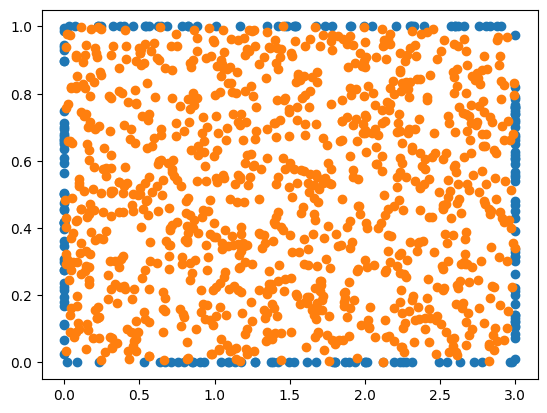

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

num_domain = 10000
num_test = 500

DTYPE = tf.float32

# set the boundary of the panel
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    y_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, y_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x = x_train[:,0:1]
y = x_train[:,1:2]

# generate boundary domain points
N_b = 100
x_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# boundary data on x edges
y_b2 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
# print(f"{x_b2=}")
X_b2 = tf.concat([x_b2, y_b2], axis=1)
# print(f"{X_b2=}")
# print(f"{x_b2=}")

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)

xval_bndry = x_bndry[:,0:1]
yval_bndry = x_bndry[:,1:2]

# plot the data to check
plt.scatter(x_bndry[:,0], x_bndry[:,1])
plt.scatter(x_train[:1000,0], x_train[:1000,1]) # only show 1000 of the points
plt.show()

In [3]:
# from tensorflow.keras.initializers import HeNormal

# now start building the tensorflow model
n_inputs = 2
n_outputs = 1
# hidden_units = [50]*3
hidden_units = [40]*3
# activation = 'tanh'
activation = 'relu'

# define custom function for automatically satisfying the BCs
def bc_function(xy):
    x, y = xy[:, 0], xy[:, 1]  # Assuming xy is a batch of [x, y]
    return x * (a - x) * y * (b - y) / a / b

def my_lambda_func(inputs):
    phi, xy = inputs
    g = tf.expand_dims(bc_function(xy), -1)  # Compute g(x, y)
    return phi * g  # Multiply phi by g(x, y)

# have to use functional API for defining the model here
# previous example uses model.add but since we have BC function here, we have to use functional API

model = tf.keras.models.Sequential()

input_layer = tf.keras.layers.Input((n_inputs,))

null_init = None
he_init = tf.keras.initializers.HeNormal() # not great because results in large init BC loss
glorot_init = tf.keras.initializers.GlorotUniform()
zero_init = tf.keras.initializers.Zeros()
lecun_init = tf.keras.initializers.LecunUniform(
    seed=None
)
# glorot init and other simple initializers result in it getting stuck near the 1-half wave mode a lot
random_init = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.05, seed=None
)
random_init2 = tf.keras.initializers.RandomUniform(
    minval=-0.05, maxval=0.05, seed=None
)
random_init3 = tf.keras.initializers.RandomUniform(minval=-10.0, maxval=10.0)
random_init4 = tf.keras.initializers.RandomNormal(mean=0.0, stddev=10.0)
random_init5 = tf.keras.initializers.RandomNormal(mean=-0.5, stddev=0.1)

hidden = input_layer
for units in hidden_units:
  hidden = tf.keras.layers.Dense(units=units, activation=activation, kernel_initializer='he_normal', bias_initializer=random_init5)(hidden)
  # debug : add dropout layers?
  hidden = tf.keras.layers.Dropout(0.2)(hidden)

# last_activation = 'tanh' # for normalized output since eigenmode
last_activation = None 
outer_hidden = tf.keras.layers.Dense(units=n_outputs, activation=last_activation, kernel_initializer='he_normal', bias_initializer=random_init5)(hidden)

# add auto BC layer, makes always simply supported
# Extract x and y from inputs
# x = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z[:, 0], axis=-1), name="extract_x")(input_coords)  # Extract x with shape (None, 1)
# y = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z[:, 1], axis=-1), name="extract_y")(input_coords)  # Extract y with shape (None, 1)

bc_layer = tf.keras.layers.Lambda(my_lambda_func)([outer_hidden, input_layer])
model = tf.keras.Model(inputs=input_layer, outputs=bc_layer)

model.build(input_shape=(None,2))

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40)        │        120 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 40)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40)        │      1,640 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 40)        │      1,640 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 40)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         41 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ dense_3[0][0],    │
│                     │                   │            │ input_layer[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,441 (13.44 KB)

 Trainable params: 3,441 (13.44 KB)

 Non-trainable params: 0 (0.00 B)

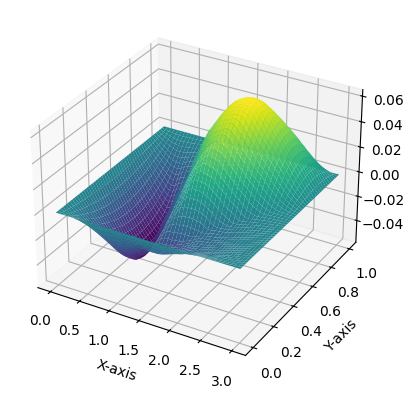

In [4]:
# plot the initial buckling mode prediction
import matplotlib.pyplot as plt
import numpy as np

def plot_mode(n=50):
    n = 50
    x_vec = np.linspace(0, a, n)
    y_vec = np.linspace(0, b, n)
    X, Y = np.meshgrid(x_vec, y_vec)
    x_flat = np.reshape(X, newshape=(n*n,1))
    y_flat = np.reshape(Y, newshape=(n*n,1))
    grid_inputs = np.concatenate([x_flat, y_flat], axis=1)
    w = model(grid_inputs)
    W = np.reshape(w, newshape=(n,n))

    # plt.figure(figsize=(8, 6))
    # colors = plt.contourf(X, Y, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
    # plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(X, Y, W, cmap='viridis')

    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    # plt.title("2D Contour Plot")
    plt.show()

plot_mode()

In [5]:
# fit and optimize the model
# epochs = 10000
epochs = 4000
# epochs = 100

import time
losses_hist = []

learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=epochs,
#     decay_rate=0.01,
#     staircase=True)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# print(f"{type(x_train)=}")

best_weights = model.get_weights()
best_loss = 1e8

for i in range(epochs + 1):
  start_time = time.time()

  with tf.GradientTape(persistent=False) as tape_model:

    # interior point energy
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(x)  # Ensure that x is watched by tape1
        tape1.watch(y)  # Ensure that y is watched by tape1
        w_raw = model(tf.stack([x[:, 0], y[:, 0]], axis=1), training=True)
        # normalize the eigenmode so it focuses on shape of eigenmode instead of just trying to make the
        # magnitudes smaller..
        w = w_raw / tf.norm(w_raw)
        # print(f"{w=}")
        
        # Compute gradients with respect to x and y
        dx = tape1.gradient(w, x)
        dy = tape1.gradient(w, y)
        # print(f"{dx=} {dy=}")

    # Compute the second derivative of dx with respect to x
    d2x = tape1.gradient(dx, x)
    # dxy = tape1.gradient(dx, y)
    d2y = tape1.gradient(dy, y)
    # print(f"{d2x=} {dxy=} {d2y=}")

    # energy version
    # ------------------
    # now compute Rayleigh's quotient and minimize the eigenvalue
    # strain_energy = tf.math.reduce_mean(D * (d4x + 2. * d2x2y + d4y))
    # stability = tf.math.reduce_mean((Nxx * d2x + 2. * Nxy * dxy + Nyy * d2y))
    # rayleigh_quotient = strain_energy / stability 

    # integrated by parts to weak form => like the energy
    lapl = d2x + d2y
    lapl_sq = tf.multiply(lapl, lapl)
    strain_energy = tf.math.reduce_mean(D * lapl_sq)
    dx_sq = tf.multiply(dx, dx)
    shear_term = 2.0 * tf.multiply(dx, dy)
    dy_sq = tf.multiply(dy, dy)
    stability = tf.math.reduce_mean(Nxx * dx_sq + Nyy * dy_sq + shear_term * Nxy)
    rayleigh_quotient = strain_energy / stability

    # also try adding zero moment loss on edges?
    # check if has nonzero moments at the boundary
    with tf.GradientTape(persistent=True) as tape_bndry:
        tape_bndry.watch(xval_bndry)  # Ensure that x is watched by tape1
        tape_bndry.watch(yval_bndry)  # Ensure that y is watched by tape1
        w = model(tf.stack([xval_bndry[:,0], yval_bndry[:,0]], axis=1), training=True)
        # print(f"{w=}")
        
        # Compute gradients with respect to x and y
        dx_bndry = tape_bndry.gradient(w, xval_bndry)
        dy_bndry = tape_bndry.gradient(w, yval_bndry)
        # print(f"{dx_bndry=}")

    # Compute the second derivative of dx with respect to x
    d2x_bndry = tape_bndry.gradient(dx_bndry, xval_bndry)
    dxy_bndry = tape_bndry.gradient(dx_bndry, yval_bndry)
    d2y_bndry = tape_bndry.gradient(dy_bndry, yval_bndry)
    # print(f"{d2x_bndry=}")

    # compute moment loss
    # seems like you need the moment loss otherwise NN doesn't satisfy zero moment condition..
    moment_scale = 100.0
    # moment_scale = 1000.0 # need stronger scale to enforce, can also set to zero to see what happens when you take it out
    _moment_loss = moment_scale * tf.reduce_mean( tf.multiply(d2x_bndry, d2x_bndry) + tf.multiply(dxy_bndry, dxy_bndry) + tf.multiply(d2y_bndry, d2y_bndry) )

    # compute total loss
    
    mse_loss = rayleigh_quotient + _moment_loss

  # compute training gradients (ML model and lambd teh eigenvalue)
  model_update_gradients = tape_model.gradient(mse_loss, model.trainable_variables)

  del tape1, tape_bndry

  # apply optimizer updates to ML model and predicted eigenvalue
  optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
  )  
  # optimizer.apply_gradients([(grads_lambda, lambd)])

  del tape_model

  eigval = rayleigh_quotient.numpy()
  moment_loss = _moment_loss.numpy()
  dt = time.time() - start_time
  print(f"Epoch: {i}\t{eigval=}\t{moment_loss=}\t{dt=}")

  train_loss = mse_loss.numpy()
  if train_loss < best_loss:
    best_loss = train_loss
    best_weights = model.get_weights()

  losses_hist += [
    {'train' : train_loss, 'eigval' : eigval, 'moments' : moment_loss}
  ]

  # if abs(train_loss) < 0.01: # error based stopping criterion
  #   break

  # if i % 1000 == 0:
  #   # y_preds = model(x_test)
  #   test_mse = tf.constant(-1)
  #   # test_mse = tf.math.reduce_mean(tf.math.square(y_preds - tf.math.sin(np.pi*x_test)), axis=0)
  #   print('Epoch: {}\tTrain Loss = {},\tTest Loss = {}'.format(i, total_mse.numpy()[0], test_mse.numpy()))

# set best weights back in
model.set_weights(best_weights)

Epoch: 0	eigval=9897.316	moment_loss=287.50183	dt=0.2837178707122803
Epoch: 1	eigval=5750.3354	moment_loss=302.18542	dt=0.22713685035705566
Epoch: 2	eigval=7996.4453	moment_loss=228.73277	dt=0.22089791297912598
Epoch: 3	eigval=8020.6885	moment_loss=218.95673	dt=0.23762822151184082
Epoch: 4	eigval=7347.698	moment_loss=205.09258	dt=0.23169898986816406
Epoch: 5	eigval=9670.094	moment_loss=240.48495	dt=0.2322225570678711
Epoch: 6	eigval=11783.935	moment_loss=221.67892	dt=0.22089767456054688
Epoch: 7	eigval=7436.273	moment_loss=270.99133	dt=0.230726957321167
Epoch: 8	eigval=7832.2803	moment_loss=230.67406	dt=0.2252037525177002
Epoch: 9	eigval=11103.806	moment_loss=250.17572	dt=0.22759699821472168
Epoch: 10	eigval=12406.329	moment_loss=181.75426	dt=0.22391676902770996
Epoch: 11	eigval=7035.5835	moment_loss=198.34953	dt=0.23896431922912598
Epoch: 12	eigval=6139.5527	moment_loss=219.71346	dt=0.2299346923828125
Epoch: 13	eigval=7414.437	moment_loss=297.16998	dt=0.24419260025024414
Epoch: 14	eig

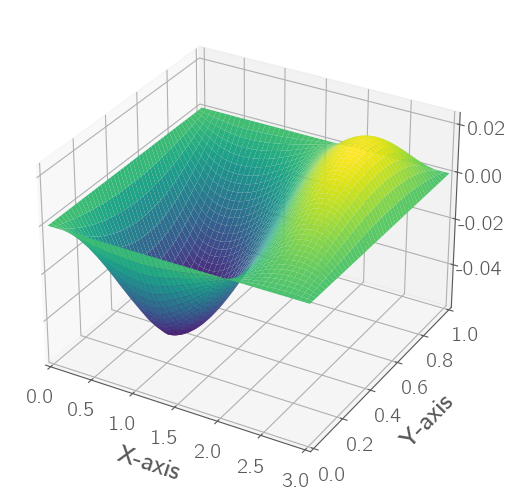

best_loss=1258.9794
Nxx=0 Nxy=100.0


In [10]:
# plot buckling mode again
# TODO : change this to also plot contour 2D view
plot_mode()

print(f"{best_loss=}")

print(f"{Nxx=} {Nxy=}")

In [7]:
# check if has nonzero moments at the boundary
with tf.GradientTape(persistent=True) as tape1:
    tape1.watch(xval_bndry)  # Ensure that x is watched by tape1
    tape1.watch(yval_bndry)  # Ensure that y is watched by tape1
    w = model(tf.stack([xval_bndry[:,0], yval_bndry[:,0]], axis=1), training=True)
    # print(f"{w_raw=}")
    
    # Compute gradients with respect to x and y
    dx = tape1.gradient(w, xval_bndry)
    dy = tape1.gradient(w, yval_bndry)
    # print(f"{dx=} {dy=}")
    # print(f"{dx=}")
    # print(f"{dy=}")

# Compute the second derivative of dx with respect to x
d2x = tape1.gradient(dx, xval_bndry)
# dxy = tape1.gradient(dx, y)
d2y = tape1.gradient(dy, yval_bndry)
# print(f"{d2x=} {d2y=}")
# print(f"{d2x=}")
# print(f"{d2y=}")

[seanFirePuter:183795] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.seanFirePuter.1000/jf.0/364445696/shared_mem_cuda_pool.seanFirePuter could be created.
[seanFirePuter:183795] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


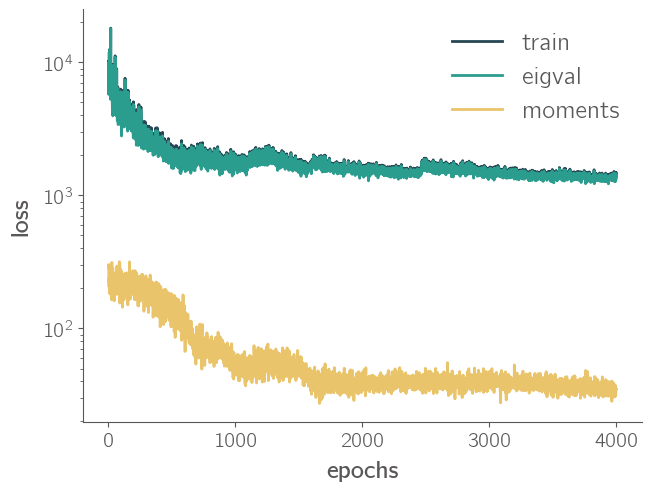

In [8]:
# plot the training losses
import matplotlib.pyplot as plt
import numpy as np
import niceplots
import ml_buckling as mlb

plt.style.use(niceplots.get_style())
ncolors = 3
# colors = plt.cm.jet(np.linspace(0.0, 1.0, ncolors))
colors = mlb.four_colors4
num_epochs = len(losses_hist)
epochs = [_ for _ in range(1, num_epochs + 1)]
# losses_hist += [
#     {'pde' : pde_loss, 'bndry' : bndry_loss, 'train' : train_loss}]
i = 0
for key in ['train', 'eigval', 'moments']:
    loss = [_[key] for _ in losses_hist]
    plt.plot(epochs, loss, label=key, color=colors[i])
    i+= 1
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.margins(x=0.05, y=0.05)
plt.legend()

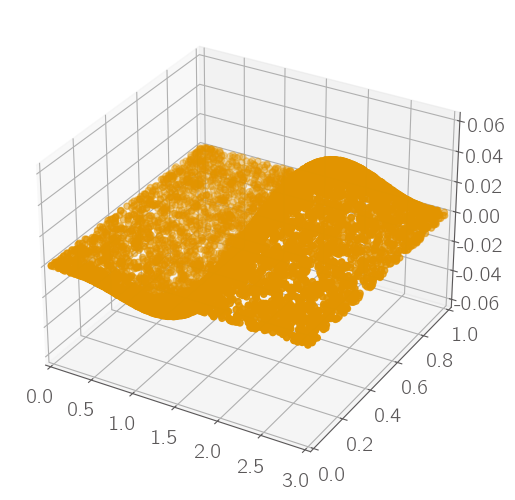

rel_err=0.8345687


In [9]:
# compute L2 norm of the solution
w_pred = model(x_train)
w_true = -1.0 * np.sin(0.667 * np.pi * x) * np.sin(np.pi * y) * np.max(np.abs(w_pred))
# print(f"{w_true=}")
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, w_true)
plt.show()

rel_err = np.max(np.abs(w_true - w_pred)) / np.max(np.abs(w_true))
print(f"{rel_err=}")